In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import datetime

# Data loading

In [2]:
data_raw = pd.read_csv('IVE_tickbidask.txt', header=None, names=['Date','Time','Price','Bid','Ask','Size'])

In [3]:
data = data_raw#.iloc[:100000]

In [7]:
data['DateTime'] = pd.to_datetime(data['Date'] + ' ' + data['Time'])
data = data.drop(columns = ['Date', 'Time'])
data = data.set_index('DateTime')

In [8]:
from scipy import stats
from bars import *

In [9]:
bars = BarSeries(data)
time_bars = bars.process_ticks(frequency='10Min')
print time_bars.head()

                        open   high      low  close  volume
DateTime                                                   
2009-09-28 09:40:00  50.7900  50.85  50.7100  50.81    9197
2009-09-28 09:50:00  50.8100  51.12  50.7833  51.07   26447
2009-09-28 10:00:00  51.0988  51.15  51.0800  51.12   53716
2009-09-28 10:10:00  51.1500  51.29  51.1500  51.27   47673
2009-09-28 10:20:00  51.2800  51.29  51.2100  51.21   30631


In [10]:
bars = TickBarSeries(data)
tick_bars = bars.process_ticks(frequency = 100)
print tick_bars.head()

                     close   high    low   open  volume
DateTime                                               
2009-09-28 09:47:22  51.06  51.07  50.71  50.79   30044
2009-09-28 09:54:38  51.13  51.15  51.06  51.06   28975
2009-09-28 10:00:15  51.21  51.21  51.08  51.13   32841
2009-09-28 10:05:50  51.21  51.28  51.20  51.21   33764
2009-09-28 10:15:13  51.25  51.29  51.19  51.22   37104


# Fixed horizon

In [96]:
WINDOW = 180
HORIZON = 60
T = 0.025

labels = []
for i in range(WINDOW, 10000, 1):
    window = tick_bars.iloc[i-WINDOW:i]
    now = tick_bars.close[i]
    future = tick_bars.close[i+HORIZON]
    ret = (future - now) / now
    
    if ret > T:
        labels.append(1)
    elif ret < -T:
        labels.append(-1)
    else:
        labels.append(0)

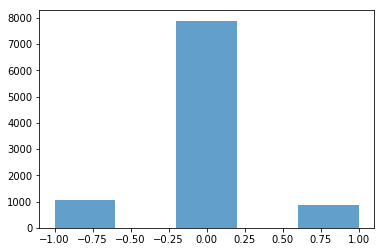

In [97]:
plt.figure()
plt.hist(labels, bins = 5, alpha = 0.7)
plt.show()

# Volatility horizon

In [98]:
labels = []
for i in range(WINDOW, 10000, 1):
    window = tick_bars.iloc[i-WINDOW:i]
    now = tick_bars.close[i]
    future = tick_bars.close[i+HORIZON]
    ret = (future - now) / now
    
    window_abs_returns = np.abs(window.close.pct_change())
    Ti = np.std(window_abs_returns) + np.mean(window_abs_returns)
    
    if ret > Ti:
        labels.append(1)
    elif ret < -Ti:
        labels.append(-1)
    else:
        labels.append(0)

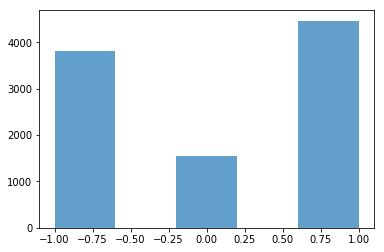

In [99]:
plt.figure()
plt.hist(labels, bins = 5, alpha = 0.7)
plt.show()

# Meta labeling

In [167]:
def get_meta_barier(future_window, last_close, min_ret, tp, sl, vertical_zero = False):
    '''
        XXX
    '''
    if vertical_zero:
        min_ret_situation = [0, 0, 0]
    else:
        min_ret_situation = [0, 0]
        
        
    differences = np.array([(fc - last_close) / last_close for fc in future_window])
    
    # Are there gonna be fluctuations within min_ret???
    min_ret_ups = np.where((differences >= min_ret) == True)[0]
    min_ret_downs = np.where((differences < -min_ret) == True)[0]
  
    if (len(min_ret_ups) == 0) and (len(min_ret_downs) == 0):
        if vertical_zero:
            min_ret_situation[2] = 1
        else:
            if differences[-1] > 0:
                min_ret_situation[0] = 1
            else:
                min_ret_situation[1] = 1            
    else:
        if len(min_ret_ups) == 0: min_ret_ups = [np.inf]
        if len(min_ret_downs) == 0: min_ret_downs = [np.inf]
        if min_ret_ups[0] > min_ret_downs[0]:
            min_ret_situation[0] = 1
        else:
            min_ret_situation[1] = 1
        
    #  Take profit and stop losses indices
    take_profit = np.where((differences >= tp) == True)[0]
    stop_loss = np.where((differences < sl) == True)[0]
    
    # Fluctuation directions coincide with take profit / stop loss actions?
    if min_ret_situation[0] == 1 and len(take_profit) != 0:
        take_action = 1
    elif min_ret_situation[1] == 1 and len(stop_loss) != 0:
        take_action = 1
    else:
        take_action = 0.
    
    return min_ret_situation, take_action

In [202]:
WINDOW = 180
HORIZON = 60

TIs = []
# MIN_RET = 0.01
TP = 0.015
SL = -0.015

X, Y, Y2 = [], [], []
for i in range(WINDOW, 10000, 1):
    window = tick_bars.iloc[i-WINDOW:i]
    now = tick_bars.close[i]
    future_window = tick_bars.close[i:i+HORIZON]
    
    window_abs_returns = np.abs(window.close.pct_change())
    Ti = np.std(window_abs_returns) + np.mean(window_abs_returns)
    
    min_ret_situation, take_action = get_meta_barier(future_window, now, Ti, TP, SL, True)
    X.append(window.close)
    Y.append(min_ret_situation)
    Y2.append(take_action)
    TIs.append(Ti)

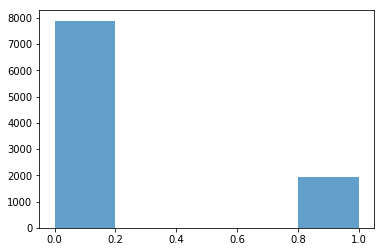

In [203]:
plt.figure()
plt.hist(Y2, bins = 5, alpha = 0.7)
plt.show()

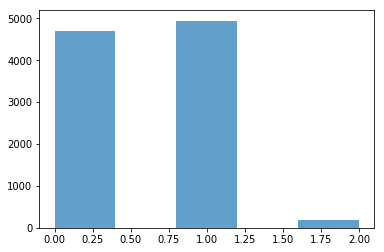

In [204]:
plt.figure()
plt.hist([np.argmax(y) for y in Y], bins = 5, alpha = 0.7)
plt.show()